<a href="https://colab.research.google.com/github/hoangthuha/assignment2-deeplearning/blob/main/Assignment_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
import time
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

In [2]:
def get_device():
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  return device

 Load and normalize CIFAR10

In [3]:
def cifar10_data(batch_size = 4, image_size = 32, transformation_name = "default"):
    transformations = transforms.Compose(
      [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),  

        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

    dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transformations)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=ResNet18_Weights.DEFAULT.transforms())
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return train_loader, val_loader, test_loader, classes


def get_accuracy_and_loss(data_loader, networks):
        networks.eval()
        accuracies = []
        loss_values = []
        total_label_size = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in data_loader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                # calculate outputs by running images through the network
                outputs = networks(images)
                # the class with the highest energy is what we choose as prediction
                # TODO: find top-k accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_label_size += labels.size(0)
                accuracy_item = (predicted == labels).sum().item()
                accuracies.append(accuracy_item)

                # losses
                loss = criterion(outputs, labels)
                loss_item = loss.item()
                loss_values.append(loss_item)
        
        accuracy_score = 100 * np.sum(accuracies) / total_label_size
        loss_value = np.mean(loss_values)
        return (accuracy_score, loss_value)

def plot_accuracy_curves(epochs, train_results):
        epoch_numbers = range(epochs)

        # accuracy curve    
        train_accuracies = [x['train_accuracy'] for x in train_results]
        val_accuracies = [x['val_accuracy'] for x in train_results]    
        plt.plot(train_accuracies, label="train")
        plt.plot(val_accuracies, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title("Accuracy vs Epoch")
        plt.show()

def plot_loss_curves(epochs, train_results):
        # Loss curve    
        epoch_numbers = range(epochs)
        train_losses = [x['train_loss'] for x in train_results]
        val_losses = [x['val_loss'] for x in train_results]    
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Loss vs Epoch")
        plt.show()


In [4]:
def train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion):
    network.train()
    train_results = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

          #fg
        train_accuracy, train_loss_value = get_accuracy_and_loss(train_loader, network)

        val_accuracy, val_loss_value = get_accuracy_and_loss(val_loader, network)

        train_result = {'epoch': epoch, 'train_loss': train_loss_value, 'train_accuracy': train_accuracy, 
                                  'val_loss': val_loss_value, 'val_accuracy': val_accuracy}
        print('Train result ', train_result)
        train_results.append(train_result)

    print('Finished Training')
    return(train_results)

Define First Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
temp = Net()
summary(temp,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


start time  2022-10-28 08:36:50.395955
Learning rate: 0.01


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.0032679507136346, 'train_accuracy': 23.91, 'val_loss': 2.005977917098999, 'val_accuracy': 24.67}
Train result  {'epoch': 1, 'train_loss': 2.0029534060537815, 'train_accuracy': 22.945, 'val_loss': 1.9967035578966141, 'val_accuracy': 23.0}
Train result  {'epoch': 2, 'train_loss': 2.057867228770256, 'train_accuracy': 20.46, 'val_loss': 2.0510380737781526, 'val_accuracy': 20.91}
Train result  {'epoch': 3, 'train_loss': 2.136929767680168, 'train_accuracy': 19.7075, 'val_loss': 2.1327084055900576, 'val_accuracy': 19.28}
Train result  {'epoch': 4, 'train_loss': 2.081574940049648, 'train_accuracy': 20.745, 'val_loss': 2.079043367242813, 'val_accuracy': 20.58}
Finished Training


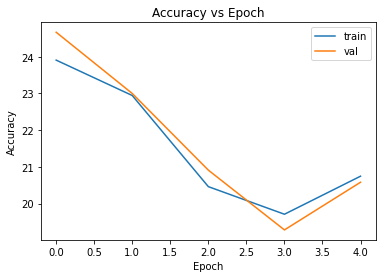

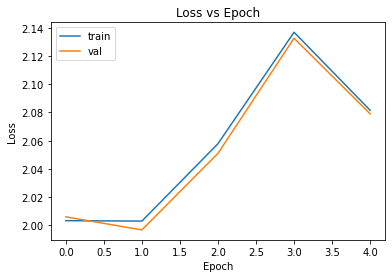

end time  2022-10-28 08:45:57.709971
547.314016


In [ ]:
# Base Model
start_time = datetime.datetime.now()
print("start time ", start_time)

for lr in [0.01]:
    print("Learning rate:", lr)
    train_loader, val_loader, test_loader, classes = cifar10_data()
    epochs = 5
    device = get_device()
    network = Net()
    network.to(device)
    optimizer = optim.SGD(network.parameters(), lr= lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
    plot_accuracy_curves(epochs, result)
    plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-27 10:32:10.238995
Learning rate: 0.1
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.3557713307619097, 'train_accuracy': 9.99, 'val_loss': 2.35798463511467, 'val_accuracy': 10.04}
Train result  {'epoch': 1, 'train_loss': 2.347928939926624, 'train_accuracy': 9.945, 'val_loss': 2.3463297995090486, 'val_accuracy': 10.22}
Train result  {'epoch': 2, 'train_loss': 2.361157913172245, 'train_accuracy': 9.945, 'val_loss': 2.3571019287109376, 'val_accuracy': 10.22}
Train result  {'epoch': 3, 'train_loss': 2.34125808532238, 'train_accuracy': 9.9425, 'val_loss': 2.33822422709465, 'val_accuracy': 10.23}
Train result  {'epoch': 4, 'train_loss': 2.373721242582798, 'train_accuracy': 9.9425, 'val_loss': 2.368370531797409, 'val_accuracy': 10.23}
Finished Training


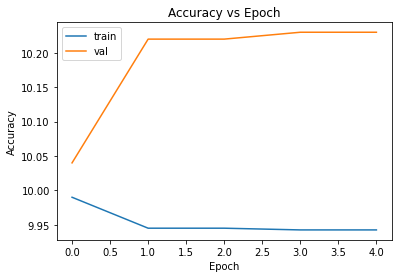

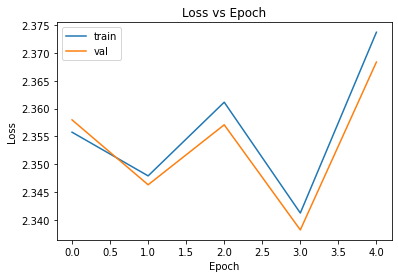

Learning rate: 0.01
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.0072483627080917, 'train_accuracy': 26.8425, 'val_loss': 2.0281788989305496, 'val_accuracy': 25.95}
Train result  {'epoch': 1, 'train_loss': 2.0302615247547626, 'train_accuracy': 26.315, 'val_loss': 2.026803896296024, 'val_accuracy': 25.88}
Train result  {'epoch': 2, 'train_loss': 1.9113202153325082, 'train_accuracy': 28.9175, 'val_loss': 1.9342706594228745, 'val_accuracy': 27.64}
Train result  {'epoch': 3, 'train_loss': 1.9096480888605118, 'train_accuracy': 27.7575, 'val_loss': 1.9240571299076081, 'val_accuracy': 26.33}
Train result  {'epoch': 4, 'train_loss': 1.9337675347149372, 'train_accuracy': 26.27, 'val_loss': 1.9481758041858672, 'val_accuracy': 25.35}
Finished Training


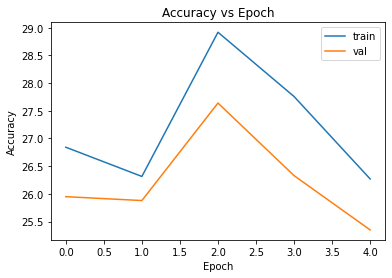

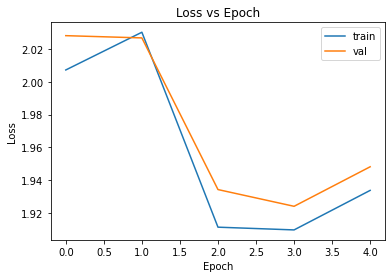

Learning rate: 0.001
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 1.4250353748902678, 'train_accuracy': 48.49, 'val_loss': 1.4350160832881929, 'val_accuracy': 47.6}
Train result  {'epoch': 1, 'train_loss': 1.256649929021299, 'train_accuracy': 55.2175, 'val_loss': 1.3038640919923783, 'val_accuracy': 53.2}
Train result  {'epoch': 2, 'train_loss': 1.1449448947004974, 'train_accuracy': 59.6225, 'val_loss': 1.2290469691723584, 'val_accuracy': 56.86}
Train result  {'epoch': 3, 'train_loss': 1.0632954739945009, 'train_accuracy': 62.7475, 'val_loss': 1.1887659770444035, 'val_accuracy': 58.12}
Train result  {'epoch': 4, 'train_loss': 1.015076459196955, 'train_accuracy': 63.9625, 'val_loss': 1.1933632958769798, 'val_accuracy': 58.29}
Finished Training


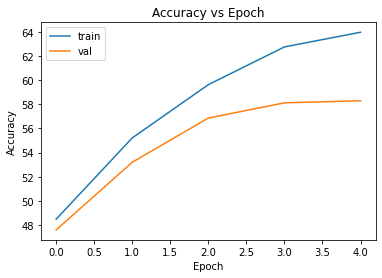

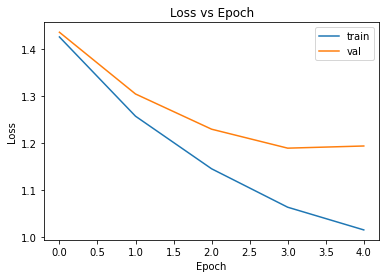

Learning rate: 0.0001
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.2843864854097364, 'train_accuracy': 18.275, 'val_loss': 2.284811021327972, 'val_accuracy': 17.77}
Train result  {'epoch': 1, 'train_loss': 1.9342218986392021, 'train_accuracy': 30.2, 'val_loss': 1.9389043534755708, 'val_accuracy': 29.51}
Train result  {'epoch': 2, 'train_loss': 1.7110920457839967, 'train_accuracy': 38.5225, 'val_loss': 1.7282889199972153, 'val_accuracy': 37.2}
Train result  {'epoch': 3, 'train_loss': 1.5765235643744469, 'train_accuracy': 43.1825, 'val_loss': 1.6099068949222564, 'val_accuracy': 41.53}
Train result  {'epoch': 4, 'train_loss': 1.4947307973623276, 'train_accuracy': 45.745, 'val_loss': 1.5412654575109481, 'val_accuracy': 44.42}
Finished Training


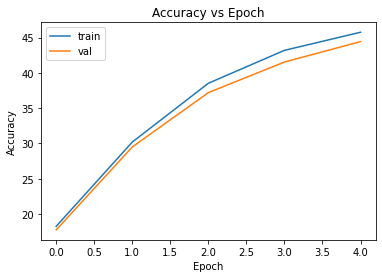

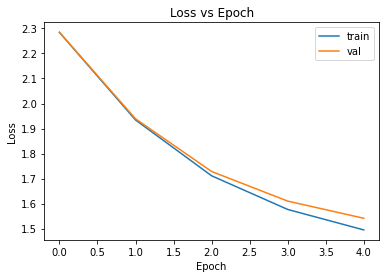

end time  2022-10-27 10:59:51.511245
1661.27225


In [ ]:
# Experiment 1 - Learning rate
start_time = datetime.datetime.now()
print("start time ", start_time)

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print("Learning rate:", lr)
    train_loader, val_loader, test_loader, classes = cifar10_data()
    epochs = 5
    device = get_device()
    network = Net()
    network.to(device)
    optimizer = optim.SGD(network.parameters(), lr= lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
    plot_accuracy_curves(epochs, result)
    plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-27 10:15:25.932749
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 1.4112762328825892, 'train_accuracy': 49.0775, 'val_loss': 1.41948367202878, 'val_accuracy': 48.24}
Train result  {'epoch': 1, 'train_loss': 1.3174191763572394, 'train_accuracy': 53.755, 'val_loss': 1.365884208509326, 'val_accuracy': 52.25}
Train result  {'epoch': 2, 'train_loss': 1.1445495549988, 'train_accuracy': 59.21, 'val_loss': 1.226997346484661, 'val_accuracy': 56.2}
Train result  {'epoch': 3, 'train_loss': 1.0230195369683206, 'train_accuracy': 63.6525, 'val_loss': 1.1638439707130193, 'val_accuracy': 59.05}
Train result  {'epoch': 4, 'train_loss': 0.972671307387203, 'train_accuracy': 65.85, 'val_loss': 1.1392214130848646, 'val_accuracy': 59.63}
Finished Training


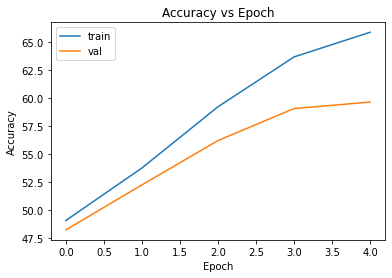

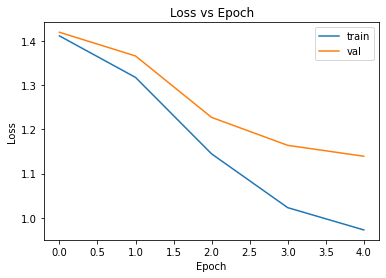

end time  2022-10-27 10:22:23.181247
417.248498


In [ ]:
#Experiment for SGD Optimizer

start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = Net()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)


end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-27 11:02:44.048499
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 1.3353917188122868, 'train_accuracy': 51.8425, 'val_loss': 1.3712915761590003, 'val_accuracy': 50.34}
Train result  {'epoch': 1, 'train_loss': 1.215631823541224, 'train_accuracy': 56.94, 'val_loss': 1.289878331080079, 'val_accuracy': 53.19}
Train result  {'epoch': 2, 'train_loss': 1.0626452833849938, 'train_accuracy': 61.8975, 'val_loss': 1.1891426791123114, 'val_accuracy': 57.55}
Train result  {'epoch': 3, 'train_loss': 1.018771946432255, 'train_accuracy': 63.31, 'val_loss': 1.1812967212118208, 'val_accuracy': 58.26}
Train result  {'epoch': 4, 'train_loss': 0.9714905364153906, 'train_accuracy': 65.2625, 'val_loss': 1.191948656505719, 'val_accuracy': 57.98}
Finished Training


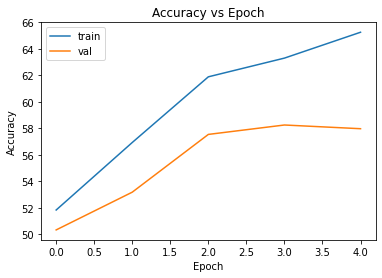

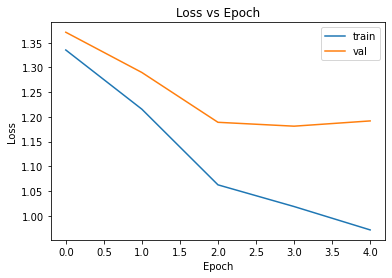

end time  2022-10-27 11:10:06.572715
442.524216


In [ ]:
#Experiment for Adam Optimizer

start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = Net()
network.to(device)
learning_rate = 0.001
optimizer = optim.Adam(network.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-27 11:10:48.143461
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 0.3388924884864595, 'train_accuracy': 44.04, 'val_loss': 0.35145069031175225, 'val_accuracy': 42.69}
Train result  {'epoch': 1, 'train_loss': 0.29658841117322154, 'train_accuracy': 48.15, 'val_loss': 0.3152519301778637, 'val_accuracy': 46.3}
Train result  {'epoch': 2, 'train_loss': 0.2499142867386894, 'train_accuracy': 53.4525, 'val_loss': 0.27806628236649555, 'val_accuracy': 50.71}
Train result  {'epoch': 3, 'train_loss': 0.22691701520552016, 'train_accuracy': 56.8175, 'val_loss': 0.2594653647074709, 'val_accuracy': 53.9}
Train result  {'epoch': 4, 'train_loss': 0.19581734327628947, 'train_accuracy': 60.9775, 'val_loss': 0.23399261447919997, 'val_accuracy': 57.17}
Finished Training


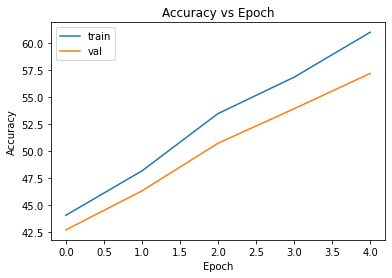

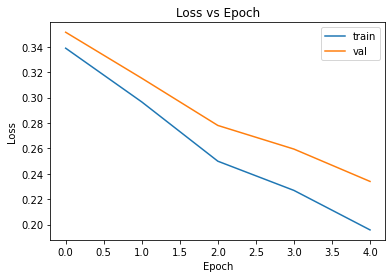

end time  2022-10-27 11:17:38.674809
410.531348


In [ ]:
# Experiment for MultiMarginLoss function
start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = Net()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.MultiMarginLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 18, 3)
        self.fc1 = nn.Linear(18 * 6 * 6, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print('shape of x after first conv layer ', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print('shape of x after second conv layer ', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        # print('shape of x after fc1 ', x.shape)
        x = self.fc3(x)
        # print('shape of x after fc3 ', x.shape)
        # breakhrejrek
        return x

temp = Net2()
summary(temp,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 30, 30]             252
         MaxPool2d-2            [-1, 9, 15, 15]               0
            Conv2d-3           [-1, 18, 13, 13]           1,476
         MaxPool2d-4             [-1, 18, 6, 6]               0
            Linear-5                  [-1, 120]          77,880
            Linear-6                   [-1, 10]           1,210
Total params: 80,818
Trainable params: 80,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.31
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


start time  2022-10-27 07:07:22.089134
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.0018847459733484, 'train_accuracy': 26.515, 'val_loss': 2.000513079929352, 'val_accuracy': 26.23}
Train result  {'epoch': 1, 'train_loss': 1.7367041438519955, 'train_accuracy': 38.42, 'val_loss': 1.7413526226282119, 'val_accuracy': 38.09}
Train result  {'epoch': 2, 'train_loss': 1.5191911955296993, 'train_accuracy': 45.1825, 'val_loss': 1.531214996123314, 'val_accuracy': 45.0}
Train result  {'epoch': 3, 'train_loss': 1.4152520814076066, 'train_accuracy': 48.775, 'val_loss': 1.441538103055954, 'val_accuracy': 47.78}
Train result  {'epoch': 4, 'train_loss': 1.3420026690497995, 'train_accuracy': 52.2575, 'val_loss': 1.3797511453211309, 'val_accuracy': 50.47}
Finished Training


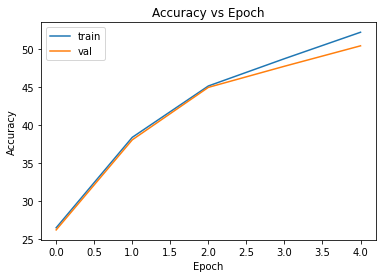

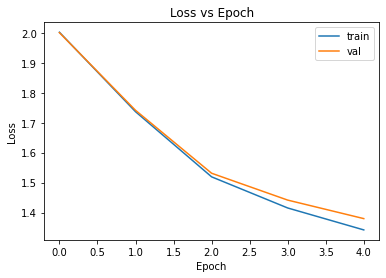

end time  2022-10-27 07:13:59.090230
397.001096


In [ ]:
# Experiment: New CNN architecture
start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network2 = Net2()
network2.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network2.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network2, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

Network2 has lower overfitting but lower accuracy compared to Network1. So we will choose Network1, eventhough it has lower fitting model but we can improve it.

In [5]:
class NetBatchNormInCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(self.conv1_bn(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(self.conv2_bn(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1_bn(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        # x = self.fc2_bn(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

start time  2022-10-27 11:19:23.397928
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 1.5869382260262965, 'train_accuracy': 41.8425, 'val_loss': 1.5948399542093277, 'val_accuracy': 40.29}
Train result  {'epoch': 1, 'train_loss': 1.322938196337223, 'train_accuracy': 51.8425, 'val_loss': 1.3703149041235447, 'val_accuracy': 49.36}
Train result  {'epoch': 2, 'train_loss': 1.2232016486126929, 'train_accuracy': 55.8375, 'val_loss': 1.2931325544863939, 'val_accuracy': 52.69}
Train result  {'epoch': 3, 'train_loss': 1.1264643570378423, 'train_accuracy': 59.19, 'val_loss': 1.2342539184868335, 'val_accuracy': 55.62}
Train result  {'epoch': 4, 'train_loss': 1.0257268660660832, 'train_accuracy': 63.37, 'val_loss': 1.1738374865412713, 'val_accuracy': 57.5}
Finished Training


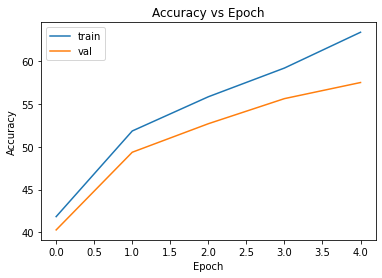

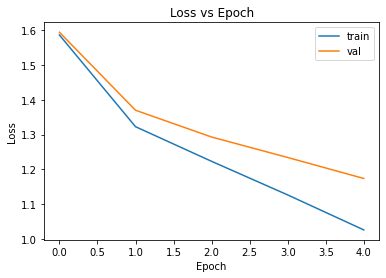

end time  2022-10-27 11:26:34.827314
431.429386


In [ ]:
# Adding Batch Normalization

start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = NetBatchNormInCnn()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-28 05:33:25.899490


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 1.7880155369102955, 'train_accuracy': 34.0925, 'val_loss': 1.7836424855470658, 'val_accuracy': 34.25}
Train result  {'epoch': 1, 'train_loss': 1.6266919699549676, 'train_accuracy': 41.2725, 'val_loss': 1.6418043740510941, 'val_accuracy': 40.8}
Train result  {'epoch': 2, 'train_loss': 1.4792532280907036, 'train_accuracy': 46.565, 'val_loss': 1.499479347038269, 'val_accuracy': 46.64}
Train result  {'epoch': 3, 'train_loss': 1.425720513394475, 'train_accuracy': 49.025, 'val_loss': 1.447751191109419, 'val_accuracy': 47.83}
Train result  {'epoch': 4, 'train_loss': 1.3863657669961453, 'train_accuracy': 49.9175, 'val_loss': 1.4025430673241615, 'val_accuracy': 49.36}
Finished Training


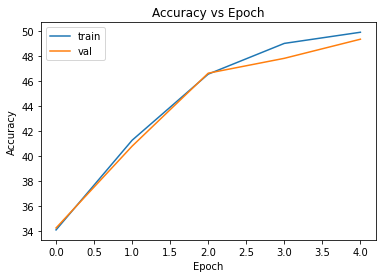

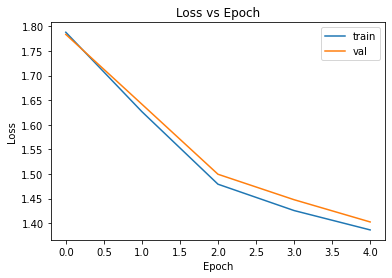

end time  2022-10-28 05:42:46.116932
560.217442


In [ ]:
# Adding Data augmentation
start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = NetBatchNormInCnn()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

Since, our model is overfitting, we tried to reduce the complexity of the model by reducing it's layer. It's summary is ### of (Net2). In this new model, the overfitting got reduced, but the model performance got reduced too. So, instead of reducing model complexity, we tried using other techniques like normalization, data augmentation and dropout. 

In [6]:
class NetBatchNormInCnnAndDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        # self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout_conv = nn.Dropout2d()
        self.dropout_fc = nn.Dropout1d()

    def forward(self, x):
        # x = self.pool(self.conv1_bn(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)
        x = self.pool(self.conv2_bn(F.relu(self.conv2(x))))
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1_bn(F.relu(self.fc1(x)))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        # x = self.fc2_bn(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

start time  2022-10-28 05:47:16.169171
Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.246568972945213, 'train_accuracy': 16.71, 'val_loss': 2.2441516319274903, 'val_accuracy': 17.04}
Train result  {'epoch': 1, 'train_loss': 1.750207246917486, 'train_accuracy': 35.755, 'val_loss': 1.732070046854019, 'val_accuracy': 36.79}
Train result  {'epoch': 2, 'train_loss': 1.637939101603627, 'train_accuracy': 40.37, 'val_loss': 1.621976891386509, 'val_accuracy': 40.64}
Train result  {'epoch': 3, 'train_loss': 1.562101642307639, 'train_accuracy': 42.955, 'val_loss': 1.5551512854218483, 'val_accuracy': 43.21}
Train result  {'epoch': 4, 'train_loss': 1.4650857575163245, 'train_accuracy': 46.7825, 'val_loss': 1.4685548952519893, 'val_accuracy': 46.37}
Finished Training


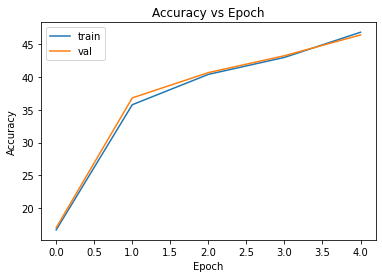

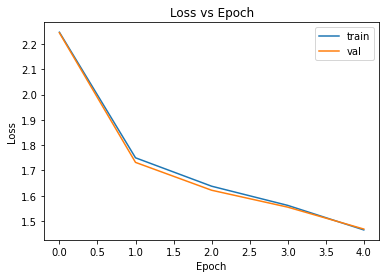

end time  2022-10-28 05:56:39.211909
563.042738


In [ ]:
# Adding dropout

start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data()
epochs = 5
device = get_device()
network = NetBatchNormInCnnAndDropout()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

start time  2022-10-28 10:26:50.260966


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.4010293297052385, 'train_accuracy': 10.035, 'val_loss': 2.404293056154251, 'val_accuracy': 9.86}
Train result  {'epoch': 1, 'train_loss': 2.3664401560783386, 'train_accuracy': 9.955, 'val_loss': 2.3622511087894438, 'val_accuracy': 10.18}
Train result  {'epoch': 2, 'train_loss': 2.356852038013935, 'train_accuracy': 10.015, 'val_loss': 2.359129728269577, 'val_accuracy': 9.94}
Train result  {'epoch': 3, 'train_loss': 2.3936938705801962, 'train_accuracy': 10.055, 'val_loss': 2.3999976110458374, 'val_accuracy': 9.78}
Train result  {'epoch': 4, 'train_loss': 2.3483353264451026, 'train_accuracy': 10.0525, 'val_loss': 2.3524973088741303, 'val_accuracy': 9.79}
Finished Training


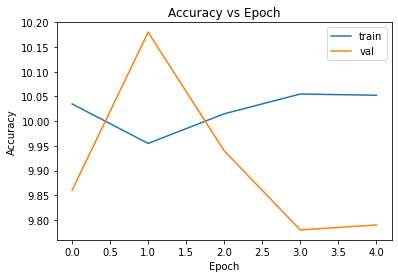

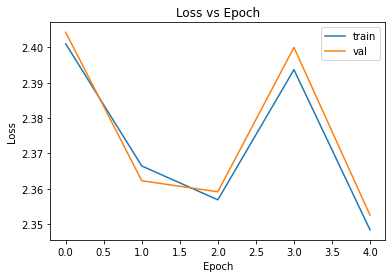

Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.3053079313278197, 'train_accuracy': 9.92, 'val_loss': 2.305104234600067, 'val_accuracy': 10.32}
Train result  {'epoch': 1, 'train_loss': 2.3096450944662092, 'train_accuracy': 9.9475, 'val_loss': 2.308373727416992, 'val_accuracy': 10.21}
Train result  {'epoch': 2, 'train_loss': 2.3173714772224425, 'train_accuracy': 9.92, 'val_loss': 2.3166255722999574, 'val_accuracy': 10.32}
Train result  {'epoch': 3, 'train_loss': 2.3054601370334624, 'train_accuracy': 10.115, 'val_loss': 2.306120783138275, 'val_accuracy': 9.54}
Train result  {'epoch': 4, 'train_loss': 2.308414226484299, 'train_accuracy': 9.9475, 'val_loss': 2.3098945850372314, 'val_accuracy': 10.21}
Finished Training


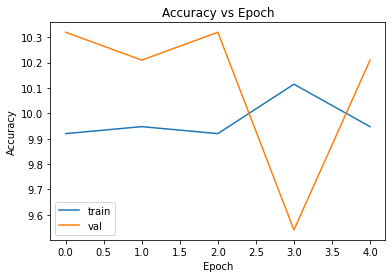

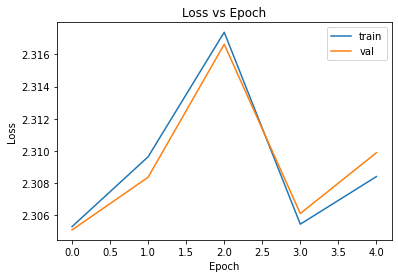

Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.21714738188982, 'train_accuracy': 18.915, 'val_loss': 2.219693400526047, 'val_accuracy': 18.3}
Train result  {'epoch': 1, 'train_loss': 1.6384550432801246, 'train_accuracy': 40.0925, 'val_loss': 1.6551549896240234, 'val_accuracy': 39.19}
Train result  {'epoch': 2, 'train_loss': 1.5232918208390474, 'train_accuracy': 44.615, 'val_loss': 1.543024453318119, 'val_accuracy': 43.79}
Train result  {'epoch': 3, 'train_loss': 1.4506058330520988, 'train_accuracy': 47.5475, 'val_loss': 1.4756646396398545, 'val_accuracy': 46.83}
Train result  {'epoch': 4, 'train_loss': 1.4166436537936329, 'train_accuracy': 48.81, 'val_loss': 1.444927138584852, 'val_accuracy': 47.87}
Finished Training


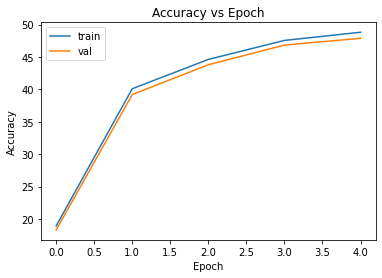

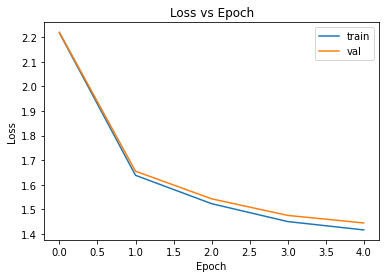

Files already downloaded and verified
Files already downloaded and verified
Train result  {'epoch': 0, 'train_loss': 2.2334611827731132, 'train_accuracy': 18.9225, 'val_loss': 2.233042735528946, 'val_accuracy': 19.27}
Train result  {'epoch': 1, 'train_loss': 1.8197764716625213, 'train_accuracy': 33.7375, 'val_loss': 1.8157108029842377, 'val_accuracy': 33.81}
Train result  {'epoch': 2, 'train_loss': 1.685126974067092, 'train_accuracy': 38.7525, 'val_loss': 1.6855857186436654, 'val_accuracy': 38.34}
Train result  {'epoch': 3, 'train_loss': 1.5997687701106071, 'train_accuracy': 41.77, 'val_loss': 1.6044915860176086, 'val_accuracy': 41.22}
Train result  {'epoch': 4, 'train_loss': 1.5654933336526156, 'train_accuracy': 43.2075, 'val_loss': 1.5765071595072746, 'val_accuracy': 42.57}
Finished Training


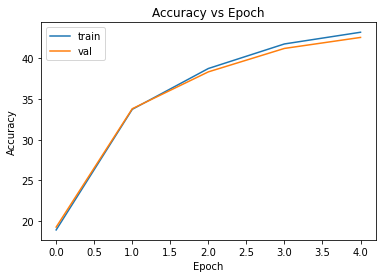

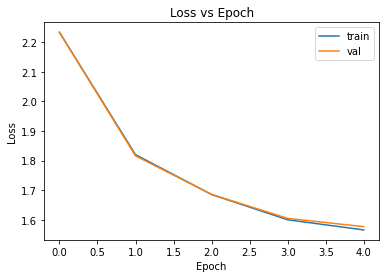

end time  2022-10-28 10:59:57.251999
1986.991033


In [7]:
# Adding dropout

start_time = datetime.datetime.now()
print("start time ", start_time)

for lr in [0.1, 0.01, 0.001, 0.0001]:
    train_loader, val_loader, test_loader, classes = cifar10_data()
    epochs = 5
    device = get_device()
    network = NetBatchNormInCnnAndDropout()
    network.to(device)
    optimizer = optim.SGD(network.parameters(), lr= lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
    plot_accuracy_curves(epochs, result)
    plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

In [ ]:
class CnnAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.alexnet(pretrained=True)
        num = 6
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.classifier[6]= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        # self.criterion = criterion

    def forward(self, x):
        return self.network(x)

start time  2022-10-27 12:18:59.986655
Files already downloaded and verified
Files already downloaded and verified
Num feat  4096
Train result  {'epoch': 0, 'train_loss': 0.553355755322933, 'train_accuracy': 81.365, 'val_loss': 0.6318551759046968, 'val_accuracy': 78.17}
Train result  {'epoch': 1, 'train_loss': 0.290637620390346, 'train_accuracy': 89.955, 'val_loss': 0.47330231952735485, 'val_accuracy': 83.69}
Train result  {'epoch': 2, 'train_loss': 0.24787659728944686, 'train_accuracy': 91.575, 'val_loss': 0.5168705719523671, 'val_accuracy': 83.12}
Train result  {'epoch': 3, 'train_loss': 0.13390660468433557, 'train_accuracy': 95.6575, 'val_loss': 0.4461067027176496, 'val_accuracy': 86.01}
Train result  {'epoch': 4, 'train_loss': 0.09037892777203049, 'train_accuracy': 96.9875, 'val_loss': 0.46512408869286237, 'val_accuracy': 86.54}
Finished Training


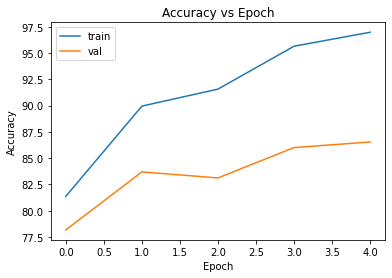

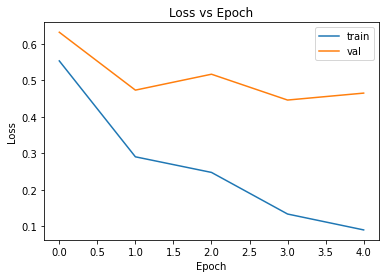

end time  2022-10-27 12:45:23.222440
1583.235785


In [ ]:
start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data(image_size = 224)
epochs = 5
device = get_device()
network = CnnAlexNet()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)

In [ ]:
class CNNResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        self.network.fc = torch.nn.Linear(num_ftrs,10)
        
    def forward(self, x):
        return self.network(x)

In [ ]:
ResNet18_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

start time  2022-10-27 23:53:15.293314
Files already downloaded and verified
Files already downloaded and verified
Num feat  512
Train result  {'epoch': 0, 'train_loss': 0.744503665626442, 'train_accuracy': 75.1, 'val_loss': 0.7587019161216915, 'val_accuracy': 74.59}
Train result  {'epoch': 1, 'train_loss': 0.6978065688929171, 'train_accuracy': 75.9325, 'val_loss': 0.7507251891955268, 'val_accuracy': 74.3}
Train result  {'epoch': 2, 'train_loss': 0.6317094882763282, 'train_accuracy': 77.865, 'val_loss': 0.6810462369038723, 'val_accuracy': 76.53}
Train result  {'epoch': 3, 'train_loss': 0.5694952807313545, 'train_accuracy': 80.1775, 'val_loss': 0.6324414608976106, 'val_accuracy': 77.98}
Train result  {'epoch': 4, 'train_loss': 0.5919208578923106, 'train_accuracy': 79.565, 'val_loss': 0.6658186961303698, 'val_accuracy': 77.1}
Finished Training


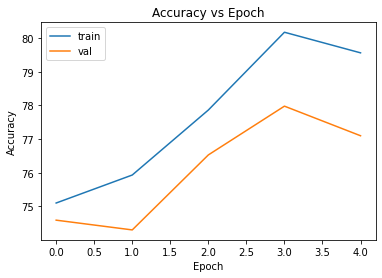

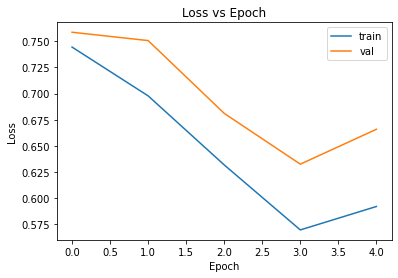

end time  2022-10-28 00:20:29.276282
1633.982968


In [ ]:
start_time = datetime.datetime.now()
print("start time ", start_time)

train_loader, val_loader, test_loader, classes = cifar10_data(image_size = 224)
epochs = 5
device = get_device()
network = CNNResNet18()
network.to(device)
learning_rate = 0.001
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
result = train_network(train_loader,val_loader, epochs, device, optimizer, network, criterion)
plot_accuracy_curves(epochs, result)
plot_loss_curves(epochs, result)

end_time =  datetime.datetime.now()
print("end time ", end_time)
difference = end_time - start_time
difference_total_seconds = difference.total_seconds()
print(difference_total_seconds)